# Studying hits from MGnify HMMER


In [73]:
import os
from pathlib import Path


# ------------------ PATH SETTINGS ------------------
PROJECT_ROOT = Path.cwd().parents[0]          # go up from notebooks/ to project/
DATA_DIR     = Path.cwd().parents[1]  / "data"
SCRIPTS_PATH = PROJECT_ROOT / "src" / "mgnify_json"


# ------------------ INPUT (EDIT THESE) ------------------


# Describe the query that produced this MGnify similarity search
query_desc = "EC3.1.1.3; PF00151"           # e.g. "EC3.1.1.74; PF00023"  <- EDIT

# MGnify job/result ID (or any unique label for this JSON)
JOB_ID = "6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1"   # <- EDIT DEPENDING ON THE JOB ID

# Where the JSON is stored: all JSONs in the same folder, no EC subfolder
JSONS_ROOT = DATA_DIR / "raw" / "jsons"
JSONS_ROOT.mkdir(parents=True, exist_ok=True)

JSON_PATH = JSONS_ROOT / f"{JOB_ID}.json"    # .../data/raw/jsons/EE98...1.json.  # <- EDIT TO CHANGE A CUSTOM PATH FOR THE JSON FILE


FASTA_DIR = DATA_DIR / "fastas" # location to save downloaded FASTA files <- EDIT if wanted, otherwise in data/fastas 
FASTA_DIR.mkdir(parents=True, exist_ok=True)



# ---------------- DERIVED PATHS ----------------


# Per-job output folder for parsed HMMER-like hits (can be wherever you want)
HMMER_DIR = DATA_DIR / "interim" / "hmmer_from_mgnify" / JOB_ID
HMMER_DIR.mkdir(parents=True, exist_ok=True)

# File paths for this job
INPUT_JSON = JSON_PATH
INPUT_CSV  = HMMER_DIR / f"{JOB_ID}.csv"     # where your JSON→CSV parser will write
CONTEXT_CSV  = HMMER_DIR / f"{JOB_ID}.context.csv"         # assembly-biome mapping


# ---------------- STORE QUERY DESCRIPTION IN README ----------------
# Single README in the jsons folder, one line per JOB_ID
README_QUERIES = JSONS_ROOT / "README_queries.tsv"

# Avoid duplicate entries for the same JOB_ID
existing_ids = set()
if README_QUERIES.exists():
    with README_QUERIES.open("r") as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue
            existing_ids.add(line.split("\t", 1)[0])  # first column = JOB_ID

if JOB_ID not in existing_ids:
    with README_QUERIES.open("a") as fh:
        # JOB_ID \t query_desc \t json_filename \t relative_path
        rel_json_path = INPUT_JSON.relative_to(PROJECT_ROOT)
        fh.write(f"{JOB_ID}\t{query_desc}\t{INPUT_JSON.name}\t{rel_json_path}\n")
else:
    print(f"[INFO] JOB_ID {JOB_ID} already present in {README_QUERIES}, not adding again.")


# ---------------- EXPORT TO ENV (for bash cells) ----------------
os.environ["scripts_path"] = str(SCRIPTS_PATH)
os.environ["JOB_ID"]       = JOB_ID
os.environ["HMMER_DIR"]    = str(HMMER_DIR)
os.environ["INPUT_CSV"]    = str(INPUT_CSV)
os.environ["INPUT_JSON"]   = str(INPUT_JSON)
os.environ["PROJECT_ROOT"]   = str(PROJECT_ROOT)
os.environ["DATA_DIR"]    = str(DATA_DIR)
os.environ["CONTEXT_CSV"]    = str(CONTEXT_CSV)

# ---------------- OPTIONAL: LOG ----------------
print("PROJECT_ROOT :", PROJECT_ROOT)
print("Scripts path :", SCRIPTS_PATH)
print("JSONS_ROOT   :", JSONS_ROOT)
print("JOB_ID       :", JOB_ID)
print("INPUT_JSON   :", INPUT_JSON)
print("HMMER_DIR    :", HMMER_DIR)
print("INPUT_CSV    :", INPUT_CSV)
print("README file  :", README_QUERIES)
print("CONTEXT_CSV  :", CONTEXT_CSV)

[INFO] JOB_ID 6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1 already present in /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/data/raw/jsons/README_queries.tsv, not adding again.
PROJECT_ROOT : /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus
Scripts path : /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/src/mgnify_json
JSONS_ROOT   : /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/data/raw/jsons
JOB_ID       : 6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1
INPUT_JSON   : /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/data/raw/jsons/6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1.json
HMMER_DI

## For the HMMER output

Runs: `4_parse_hmmer_json`
Purpose:
- Convert an HMMER/MGnify-style **JSON results file** into a flat **CSV table**.
- Emits one row per detected domain within each hit.
- **If a hit has no`domains, emits a single empty row so it is not lost**

Outcome: `{JOB_ID_ph}.csv`

In [69]:
%%bash

echo ${scripts_path}
python ${scripts_path}/4_parse_hmmer_json.py \
  ${INPUT_JSON} \
  ${INPUT_CSV} \
  2>&1 | sed -n '1,200p'

/Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/BioNexus/src/mgnify_json


dom_hmm_name
Lipase    852
Name: count, dtype: int64


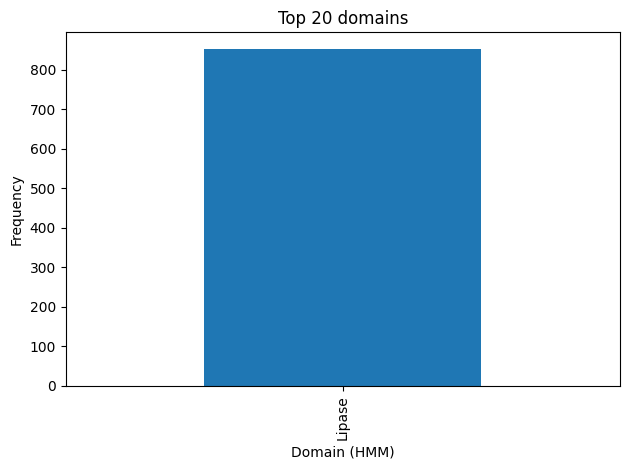

In [70]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

csv = Path(INPUT_CSV)  # ya es una ruta válida

df = pd.read_csv(csv)

# Filtra filas con dominio válido
df = df[df["dom_hmm_name"].notna() & (df["dom_hmm_name"]!="")]

# 1) Simple count by domain
counts = df["dom_hmm_name"].value_counts()
print(counts)

# Save table
#counts.to_csv("domain_counts.tsv", sep="\t", header=["count"])

# 2) Top 20 
ax = counts.head(20).plot(kind="bar")
ax.set_xlabel("Domain (HMM)")
ax.set_ylabel("Frequency")
ax.set_title("Top 20 domains")
plt.tight_layout()
plt.show()

#### In case no filtering is done

In [71]:
%%bash
head ${INPUT_CSV}

tail -n +2 ${INPUT_CSV} | cut -d',' -f1 | sort -u | wc -l


hit_acc,hit_name,hit_score,hit_bias,hit_pvalue,hit_evalue,n_domains,dom_bitscore,dom_bias,dom_ievalue,dom_cevalue,dom_aliL,dom_aliId,dom_aliSim,dom_hmm_from,dom_hmm_to,dom_hmm_acc,dom_hmm_name,dom_sq_from,dom_sq_to,dom_model_cov,dom_seq_cov,studies,assemblies,biomes,samples,extlink
MGYP001358270022,MGYP001358270022,555.6,0.0,-392.894958161373,1.7e-162,1,555.314208984375,0.00,2.0e-162,7.1e-167,503,0.62797619047619,0.955357142857143,1,336,PF00151.26,Lipase,52,388,336,337,ERP112340|https://www.ebi.ac.uk/metagenomics/studies/ERP112340,ERZ786672|https://www.ebi.ac.uk/metagenomics/assemblies/ERZ786672,422,112340,https://www.ebi.ac.uk/metagenomics/proteins/MGYP001358270022
MGYP001170015402,MGYP001170015402,453.2,0.0,-321.181891614566,2.3e-131,2,452.489349365234,0.00,3.8e-131,1.3e-135,504,0.475460122699386,0.917177914110429,11,336,PF00151.26,Lipase,14,342,326,329,ERP112340|https://www.ebi.ac.uk/metagenomics/studies/ERP112340,ERZ786676|https://www.ebi.ac.uk/metagenomics/assemblies/ERZ786676,422

### Link to biomes

**Random 500 hits**


This part reads a CSV containing MGnify assemblies, looks up the biome
associated with each assembly using the MGnify API, and writes an annotated
output file. A local cache is used to avoid repeated API calls.

#### Steps 

1. **Load input CSV** and find the `assemblies` column.
2. **Extract unique assembly IDs** (cleaning separators like `;` and `|`).
3. **If >500 assemblies**, randomly sample 500; otherwise use all.
4. For each assembly:
   - If already in the **cache**, reuse the cached Biome ID.
   - Otherwise:
     - Query MGnify: `assembly → sample → biome`
     - Save the result to both the output file and the cache.
5. **Deduplicate** and clean the final output and cache.

#### Output

- A `<input>.context.csv` file with `Assembly,Biome_ID`
- An updated, persistent cache: `erz_biome_cache.csv`

In [48]:
%%bash
set -uo pipefail    # safer: keep undefined-var + pipefail, drop -e

# --- ENSURE REQUIRED ENV VARS ---
: "${INPUT_CSV:?INPUT_CSV not set}"

# --- INPUTS ---
INPUT="${INPUT_CSV}"
OUT="${INPUT%.csv}.context.csv"
CACHE="${PROJECT_ROOT}/data/raw/erz_biome_cache.csv"

# --- REQUIREMENTS ---
command -v jq   >/dev/null 2>&1 || { echo "ERROR: jq required" >&2; exit 1; }
command -v curl >/dev/null 2>&1 || { echo "ERROR: curl required" >&2; exit 1; }
CURL='curl -sS --fail-with-body --retry 3 --connect-timeout 10 --max-time 30 --http1.1'

# --- CHECK INPUT EXISTS ---
[[ -f "$INPUT" ]] || { echo "ERROR: not found input CSV: $INPUT" >&2; exit 2; }

# --- INIT OUTPUT FILES ---
printf "Assembly,Biome_ID\n" > "$OUT"
[[ -f "$CACHE" ]] || printf "Assembly,Biome_ID\n" > "$CACHE"

# helper: retrieve from cache
get_cached_bid() {
  awk -F',' -v e="$1" 'NR>1 && $1==e {print $2; exit}' "$CACHE"
}

# --- Extract unique ERZ assemblies ---
ERZ_TMP="$(mktemp)"
awk -F',' '
  NR==1 {
    for(i=1;i<=NF;i++) {
      col=$i
      gsub(/\r/, "", col)
      gsub(/^[ \t]+|[ \t]+$/, "", col)
      h[col]=i
    }
    if(!("assemblies" in h)) {
      print "ERROR: missing header: assemblies" > "/dev/stderr"
      exit 2
    }
    A=h["assemblies"]
    next
  }
  {
    n=split($A,t,/;/)
    for(k=1;k<=n;k++){
      gsub(/^[ \t]+|[ \t]+$/, "", t[k])
      if(t[k]=="") continue
      split(t[k],u,/\|/)
      if(u[1]!="") print u[1]
    }
  }
' "$INPUT" | sort -u > "$ERZ_TMP"

TOTAL=$(wc -l < "$ERZ_TMP")
echo "Assemblies (unique) found: $TOTAL" >&2

# --- Downsample if >500 assemblies ---
ERZ_LIST="$ERZ_TMP"
if (( TOTAL > 500 )); then
  ERZ_SUBSET="$(mktemp)"
  if command -v shuf >/dev/null 2>&1; then
    shuf -n 500 "$ERZ_TMP" > "$ERZ_SUBSET"
  elif command -v gshuf >/dev/null 2>&1; then
    gshuf -n 500 "$ERZ_TMP" > "$ERZ_SUBSET"
  else
    # Reservoir sampling
    awk -v k=500 '
      BEGIN {
        s=ENVIRON["SEED"]
        if(s!="") srand(s)
      }
      NR<=k { a[NR]=$0; next }
      {
        i=int(rand()*NR)+1
        if(i<=k) a[i]=$0
      }
      END {
        n=(k<NR?k:NR)
        for(i=1;i<=n;i++) print a[i]
      }
    ' "$ERZ_TMP" > "$ERZ_SUBSET"
  fi
  ERZ_LIST="$ERZ_SUBSET"
  echo ">500 assemblies: using random subset of 500." >&2
else
  echo "≤500 assemblies: using full list." >&2
fi

TOTAL_LIST=$(wc -l < "$ERZ_LIST")
echo "Assemblies to process: $TOTAL_LIST" >&2

# --- MAIN LOOP ---
i=0
while IFS= read -r ERZ; do
  [[ -n "$ERZ" ]] || continue
  i=$((i+1))
  printf "[%d/%d] %s ... " "$i" "$TOTAL_LIST" "$ERZ" >&2

  # Try cache
  BID="$(get_cached_bid "$ERZ")"
  if [[ -n "${BID:-}" ]]; then
    echo "cache" >&2
    printf "%s,%s\n" "$ERZ" "$BID" >> "$OUT"
    continue
  fi

  # --- ERZ → SRS ---
  AJ="$($CURL "https://www.ebi.ac.uk/metagenomics/api/v1/assemblies/${ERZ}" 2>/dev/null || true)"
  SRS="$(printf '%s' "$AJ" | jq -r '.data.relationships.samples.data[0].id // empty' 2>/dev/null || echo "")"

  # --- SRS → BID ---
  if [[ -n "$SRS" ]]; then
    SJ="$($CURL "https://www.ebi.ac.uk/metagenomics/api/v1/samples/${SRS}" 2>/dev/null || true)"
    BID="$(printf '%s' "$SJ" | jq -r '.data.relationships.biome.data.id // empty' 2>/dev/null || echo "")"
  fi

  [[ -n "$BID" ]] || BID="NA"
  echo "api → $BID" >&2

  printf "%s,%s\n" "$ERZ" "$BID" >> "$OUT"
  printf "%s,%s\n" "$ERZ" "$BID" >> "$CACHE"

done < "$ERZ_LIST"

rm -f "$ERZ_TMP" "${ERZ_SUBSET:-}"

# --- DEDUPLICATE (keep header) ---
tmp="$OUT.tmp"
tail -n +2 "$OUT" | sort -u > "$tmp"
{ echo "Assembly,Biome_ID"; cat "$tmp"; } > "$OUT"
rm -f "$tmp"

ct="$CACHE.tmp"
tail -n +2 "$CACHE" | sort -u > "$ct"
{ echo "Assembly,Biome_ID"; cat "$ct"; } > "$CACHE"
rm -f "$ct"

echo "Done → $OUT" >&2

Assemblies (unique) found: 636
>500 assemblies: using random subset of 500.
Assemblies to process: 500
[1/500] ERZ778019 ... cache
[2/500] ERZ4873969 ... cache
[3/500] ERZ505132 ... cache
[4/500] ERZ2944967 ... cache
[5/500] ERZ508588 ... cache
[6/500] ERZ4560480 ... cache
[7/500] ERZ842408 ... cache
[8/500] ERZ781401 ... cache
[9/500] ERZ508592 ... cache
[10/500] ERZ1033989 ... cache
[11/500] ERZ724514 ... cache
[12/500] ERZ841138 ... cache
[13/500] ERZ1066130 ... cache
[14/500] ERZ773356 ... cache
[15/500] ERZ773189 ... cache
[16/500] ERZ1767612 ... cache
[17/500] ERZ1688060 ... cache
[18/500] ERZ781403 ... cache
[19/500] ERZ778039 ... cache
[20/500] ERZ3455820 ... cache
[21/500] ERZ1066140 ... cache
[22/500] ERZ794932 ... cache
[23/500] ERZ650309 ... cache
[24/500] ERZ795064 ... cache
[25/500] ERZ508603 ... cache
[26/500] ERZ4201007 ... cache
[27/500] ERZ941552 ... cache
[28/500] ERZ650154 ... cache
[29/500] ERZ4562243 ... cache
[30/500] ERZ1066110 ... cache
[31/500] ERZ840881 ... c

**Instead of 500 random hits -> top 500**

In [76]:
%%bash
set -uo pipefail    # keep undefined-var + pipefail, no -e

# --- ENSURE REQUIRED ENV VARS ---
: "${INPUT_CSV:?INPUT_CSV not set}"
: "${PROJECT_ROOT:?PROJECT_ROOT not set}"

# --- INPUTS ---
INPUT="${INPUT_CSV}"
OUT="${CONTEXT_CSV}"
CACHE="${DATA_DIR}/raw/erz_biome_cache.csv"

# --- REQUIREMENTS ---
command -v jq   >/dev/null 2>&1 || { echo "ERROR: jq required" >&2; exit 1; }
command -v curl >/dev/null 2>&1 || { echo "ERROR: curl required" >&2; exit 1; }
CURL='curl -sS --fail-with-body --retry 3 --connect-timeout 10 --max-time 30 --http1.1'

# --- CHECK INPUT EXISTS ---
[[ -f "$INPUT" ]] || { echo "ERROR: not found input CSV: $INPUT" >&2; exit 2; }

# --- INIT OUTPUT FILES ---
printf "Assembly,Biome_ID\n" > "$OUT"
[[ -f "$CACHE" ]] || printf "Assembly,Biome_ID\n" > "$CACHE"

# helper: retrieve from cache
get_cached_bid() {
  awk -F',' -v e="$1" 'NR>1 && $1==e {print $2; exit}' "$CACHE"
}

# --- Restrict to top 500 hits (rows) if needed ---
LINES=$(wc -l < "$INPUT")
TOP_CSV="$INPUT"

# If more than 1 header + 500 data lines, keep only header + first 500 hits
if (( LINES > 501 )); then
  TOP_CSV="$(mktemp)"
  {
    # header
    head -n 1 "$INPUT"
    # first 500 data rows (assumed already sorted by score upstream)
    tail -n +2 "$INPUT" | head -n 500
  } > "$TOP_CSV"
  echo "More than 500 hits: using top 500 rows from INPUT." >&2
else
  echo "≤500 hits: using full INPUT as is." >&2
fi

# --- Extract unique ERZ assemblies from TOP_CSV ---
ERZ_TMP="$(mktemp)"
awk -F',' '
  NR==1 {
    for(i=1;i<=NF;i++) {
      col=$i
      gsub(/\r/, "", col)
      gsub(/^[ \t]+|[ \t]+$/, "", col)
      h[col]=i
    }
    if(!("assemblies" in h)) {
      print "ERROR: missing header: assemblies" > "/dev/stderr"
      exit 2
    }
    A=h["assemblies"]
    next
  }
  {
    n=split($A,t,/;/)
    for(k=1;k<=n;k++){
      gsub(/^[ \t]+|[ \t]+$/, "", t[k])
      if(t[k]=="") continue
      split(t[k],u,/\|/)
      if(u[1]!="") print u[1]
    }
  }
' "$TOP_CSV" | sort -u > "$ERZ_TMP"

TOTAL=$(wc -l < "$ERZ_TMP")
echo "Assemblies (unique) in top hits: $TOTAL" >&2

ERZ_LIST="$ERZ_TMP"
TOTAL_LIST="$TOTAL"
echo "Assemblies to process: $TOTAL_LIST" >&2

# --- MAIN LOOP ---
i=0
while IFS= read -r ERZ; do
  [[ -n "$ERZ" ]] || continue
  i=$((i+1))
  printf "[%d/%d] %s ... " "$i" "$TOTAL_LIST" "$ERZ" >&2

  # Try cache
  BID="$(get_cached_bid "$ERZ")"
  if [[ -n "${BID:-}" ]]; then
    echo "cache" >&2
    printf "%s,%s\n" "$ERZ" "$BID" >> "$OUT"
    continue
  fi

  # --- ERZ → SRS ---
  AJ="$($CURL "https://www.ebi.ac.uk/metagenomics/api/v1/assemblies/${ERZ}" 2>/dev/null || true)"
  SRS="$(printf '%s' "$AJ" | jq -r '.data.relationships.samples.data[0].id // empty' 2>/dev/null || echo "")"

  # --- SRS → BID ---
  if [[ -n "$SRS" ]]; then
    SJ="$($CURL "https://www.ebi.ac.uk/metagenomics/api/v1/samples/${SRS}" 2>/dev/null || true)"
    BID="$(printf '%s' "$SJ" | jq -r '.data.relationships.biome.data.id // empty' 2>/dev/null || echo "")"
  fi

  [[ -n "$BID" ]] || BID="NA"
  echo "api → $BID" >&2

  printf "%s,%s\n" "$ERZ" "$BID" >> "$OUT"
  printf "%s,%s\n" "$ERZ" "$BID" >> "$CACHE"

done < "$ERZ_LIST"

rm -f "$ERZ_TMP"
[[ "$TOP_CSV" != "$INPUT" ]] && rm -f "$TOP_CSV"

# --- DEDUPLICATE (keep header) ---
tmp="$OUT.tmp"
tail -n +2 "$OUT" | sort -u > "$tmp"
{ echo "Assembly,Biome_ID"; cat "$tmp"; } > "$OUT"
rm -f "$tmp"

ct="$CACHE.tmp"
tail -n +2 "$CACHE" | sort -u > "$ct"
{ echo "Assembly,Biome_ID"; cat "$ct"; } > "$CACHE"
rm -f "$ct"

echo "Done → $OUT" >&2

More than 500 hits: using top 500 rows from INPUT.
Assemblies (unique) in top hits: 185
Assemblies to process: 185
[1/185] ERZ1022724 ... cache
[2/185] ERZ1022825 ... cache
[3/185] ERZ1023158 ... cache
[4/185] ERZ1023261 ... cache
[5/185] ERZ1023368 ... cache
[6/185] ERZ1023397 ... cache
[7/185] ERZ1029860 ... cache
[8/185] ERZ1029970 ... cache
[9/185] ERZ1029984 ... cache
[10/185] ERZ1030044 ... cache
[11/185] ERZ1030050 ... cache
[12/185] ERZ1030086 ... cache
[13/185] ERZ1030092 ... cache
[14/185] ERZ1030094 ... cache
[15/185] ERZ1030096 ... cache
[16/185] ERZ1030114 ... cache
[17/185] ERZ1030128 ... cache
[18/185] ERZ1030148 ... cache
[19/185] ERZ1030161 ... cache
[20/185] ERZ1030209 ... cache
[21/185] ERZ1030215 ... cache
[22/185] ERZ1034367 ... cache
[23/185] ERZ1034369 ... cache
[24/185] ERZ1034371 ... cache
[25/185] ERZ1066118 ... cache
[26/185] ERZ1066119 ... cache
[27/185] ERZ1066120 ... cache
[28/185] ERZ1066123 ... cache
[29/185] ERZ1066125 ... cache
[30/185] ERZ1066126 ... 

## Fasta files

### Select a subset of hits (biomes of interest + up to top 10% of the hits)

In [49]:
import pandas as pd
from collections import Counter
from pathlib import Path

def load_csv_with_fallback(path: Path) -> pd.DataFrame:
    """Load CSV with multiple fallback strategies."""
    try:
        df = pd.read_csv(path, engine='python')
        if len(df.columns) == 1:  # Fallback if header wasn't split
            df = pd.read_csv(path, sep=",", engine='python')
        if len(df.columns) == 1:  # Still broken? Force header=None
            df = pd.read_csv(path, sep=",", header=None, engine='python')
            print(f"⚠ Warning: Header missing or malformed in {path}. Columns auto-generated.")
    except Exception as e:
        raise ValueError(f"Failed to read {path}: {e}")
    return df

def subset_hits_by_score_and_biome(input_csv: Path,
                                   context_csv: Path,
                                   output_csv: Path,
                                   top_percentage: float = 10.0) -> None:
    """Subset hits based on top percentage of hit_score and biomes of interest."""

    # Load files with fallback logic
    df = load_csv_with_fallback(input_csv)
    context_df = load_csv_with_fallback(context_csv)

    # Clean headers
    df.columns = df.columns.str.strip()
    context_df.columns = context_df.columns.str.strip()

    # Validate columns
    if "hit_score" not in df.columns or "assemblies" not in df.columns:
        raise ValueError(f"Input CSV missing required columns. Found: {df.columns.tolist()}")
    if "Assembly" not in context_df.columns or "Biome_ID" not in context_df.columns:
        raise ValueError(f"Context CSV missing required columns. Found: {context_df.columns.tolist()}")

    total_rows_original = len(df)

    # Map assemblies to biomes
    assembly_to_biome = dict(zip(context_df["Assembly"], context_df["Biome_ID"]))

    def map_biomes(assemblies_str):
        assemblies = [
            a.split("|")[0].strip()
            for a in str(assemblies_str).split(";")
            if a.strip()
        ]
        biomes = [assembly_to_biome[a] for a in assemblies if a in assembly_to_biome]
        return biomes

    df["biomes"] = df["assemblies"].apply(map_biomes)

    # Filter empty biome lists
    df = df[df["biomes"].apply(lambda x: isinstance(x, list) and len(x) > 0)]
    rows_after_filtering = len(df)

    # Sort by hit_score (highest first)
    df_sorted = df.sort_values(by="hit_score", ascending=False)

    # Top percentage
    top_n = max(1, int(len(df_sorted) * (top_percentage / 100)))
    top_hits = df_sorted.head(top_n)

    # Biomes of interest (you can tweak this list)
    biomes_of_interest = [
        "root: Environmental:Aquatic:Freshwater",
        "root: Environmental: Terrestrial: Soil",
        "root: Environmental:Aquatic:Marine",
        "root: Engineered: Solid waste: Composting",
        "root: Engineered: Lab enrichment:Defined media:Anaerobic media",
        "root: Engineered: Wastewater:Nutrient removal:Dissolved organics (anaerobic)",
    ]
    normalized_interest = [b.replace(" ", "") for b in biomes_of_interest]

    biome_hits = df_sorted[
        df_sorted["biomes"].apply(
            lambda b_list: isinstance(b_list, list) and any(
                isinstance(b, str) and b.replace(" ", "").startswith(b_interest)
                for b_interest in normalized_interest
                for b in b_list
            )
        )
    ]

    # Combine subsets
    subset = pd.concat([top_hits, biome_hits])

    # Convert biomes list to string BEFORE deduplication
    subset["biomes"] = subset["biomes"].apply(
        lambda x: "; ".join(x) if isinstance(x, list) else ""
    )
    subset = subset.drop_duplicates()

    # Save output
    output_csv.parent.mkdir(parents=True, exist_ok=True)
    subset.to_csv(output_csv, index=False)

    # Summary report
    unique_biomes = set()
    biome_counts = Counter()
    for b_str in subset["biomes"]:
        for b in b_str.split("; "):
            if b.strip():
                unique_biomes.add(b.strip())
                biome_counts[b.strip()] += 1

    print("\n=== SUMMARY REPORT ===")
    print(f"Total rows in original file: {total_rows_original}")
    print(f"Rows after filtering empty biomes: {rows_after_filtering}")
    print(f"Top {top_percentage}% rows: {len(top_hits)}")
    print(f"Biome matches (interest list): {len(biome_hits)}")
    print(f"Unique biomes in subset: {len(unique_biomes)}")
    print(f"Subset saved to: {output_csv}")
    print("\nTop 10 biomes in subset:")
    for biome, count in biome_counts.most_common(10):
        print(f"{biome}: {count}")

In [77]:
OUTPUT_CSV  = DATA_DIR / "processed" / f"{JOB_ID}_biome_subset.csv"


subset_hits_by_score_and_biome(
    input_csv=INPUT_CSV,
    context_csv=CONTEXT_CSV,
    output_csv=OUTPUT_CSV,
    top_percentage=10.0,   # or 5, 20, etc.
)


=== SUMMARY REPORT ===
Total rows in original file: 873
Rows after filtering empty biomes: 755
Top 10.0% rows: 75
Biome matches (interest list): 380
Unique biomes in subset: 22
Subset saved to: /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/data/processed/6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1_biome_subset.csv

Top 10 biomes in subset:
root:Environmental:Aquatic:Marine: 202
root:Environmental:Aquatic:Marine:Intertidal zone:Coral reef: 59
root:Environmental:Aquatic:Marine:Oceanic: 36
root:Host-associated:Human:Skin: 27
root:Environmental:Aquatic:Marine:Sediment: 26
root:Environmental:Aquatic:Freshwater: 21
root:Environmental:Aquatic:Freshwater:Lake: 17
root:Environmental:Aquatic:Marine:Marginal Sea: 14
root:Environmental:Aquatic:Freshwater:Sediment: 7
root:Host-associated:Mammals:Digestive system:Fecal: 5


### Getting fasta files

In [80]:
import pandas as pd
import requests
from pathlib import Path
import re


def download_fastas_for_jobs(
    data_root: Path,
    job_ids=None,
    max_ids_per_job=None,
):
    """
    Download FASTAs from the MGnify protein portal for MGYPs from one or more JOB_IDs.

    - data_root: Path where to start searching (e.g. DATA_DIR).
    - job_ids:
        * None  -> detect all *_biome_subset.csv files recursively under data_root
        * list  -> process only those JOB_IDs
    - max_ids_per_job:
        * None  -> all MGYP per job
        * int   -> at most N MGYP per job
    """

    search_root = data_root               # e.g. DATA_DIR
    esma_root   = data_root / "fastas"    # where FASTAs will be stored

    # --- Detect JOB_IDs and CSV paths ---
    if job_ids is None:
        # Find all *_biome_subset.csv recursively
        subset_files = sorted(search_root.rglob("*_biome_subset.csv"))
        if not subset_files:
            raise FileNotFoundError(f"No *_biome_subset.csv found under {search_root}")

        # job_entries: list of (JOB_ID, actual_csv_path)
        job_entries = [
            (p.stem.replace("_biome_subset", ""), p)
            for p in subset_files
        ]
        print("Detected JOB_IDs:", [jid for jid, _ in job_entries])

    else:
        # If the user provides job_ids, search their files individually
        job_entries = []
        for jid in job_ids:
            jid = str(jid)
            matches = list(search_root.rglob(f"{jid}_biome_subset.csv"))
            if not matches:
                print(f"[WARN] No subset file for JOB_ID={jid} under {search_root}")
                continue
            job_entries.append((jid, matches[0]))

        if not job_entries:
            print("[WARN] No subset files found for the provided JOB_IDs.")
            return

    # --- Helper: detect MGYP column ---
    def get_mgyp_ids(df: pd.DataFrame, max_ids=None):
        if "MGYP" in df.columns:
            ids = df["MGYP"].dropna().astype(str).unique()
        else:
            ids = df.iloc[:, 0].dropna().astype(str).unique()
        if max_ids is not None:
            ids = ids[:max_ids]
        return ids

    # --- Helper: download one FASTA from MGnify portal (Bash equivalent) ---
    def download_fasta_from_mgnify(
        mgyp_id: str,
        ok_dir: Path,
        nf_list_file: Path,
        ok_list_file: Path,
    ) -> bool:
        """
        Mimic the Bash logic:

        URL = https://www.ebi.ac.uk/metagenomics/proteins/MGYPxxxx/
        Extract amino acid sequence from the 'Sequence Viewer' block,
        keep only ACDEFGHIKLMNPQRSTVWY, wrap at 60 chars.
        """
        url = f"https://www.ebi.ac.uk/metagenomics/proteins/{mgyp_id}/"
        try:
            r = requests.get(url, timeout=30)
            if r.status_code != 200:
                raise RuntimeError(f"HTTP {r.status_code}")

            html = r.text

            # Try to extract between "Sequence Viewer" and "Copy"
            seq_block = ""
            start_idx = html.find("Sequence Viewer")
            if start_idx != -1:
                # Prefer "Copy" as end marker
                end_idx = html.find("Copy", start_idx)
                if end_idx == -1:
                    # Fallback: "Sequence" as end marker
                    end_idx = html.find("Sequence", start_idx)
                if end_idx == -1:
                    end_idx = len(html)
                seq_block = html[start_idx:end_idx]

            # Keep only amino acid letters
            seq = re.sub(r"[^ACDEFGHIKLMNPQRSTVWY]", "", seq_block)

            if not seq:
                raise RuntimeError("Empty sequence after filtering")

            # Wrap at 60 characters
            wrapped = "\n".join(seq[i:i+60] for i in range(0, len(seq), 60))
            fasta_content = f">{mgyp_id}\n{wrapped}\n"

            (ok_dir / f"{mgyp_id}.fasta").write_text(fasta_content)
            with ok_list_file.open("a") as fh:
                fh.write(f"{mgyp_id}\n")
            return True

        except Exception as e:
            # Any failure → record as not found
            print(f"[WARN] Failed to fetch {mgyp_id} from MGnify portal: {e}")
            with nf_list_file.open("a") as fh:
                fh.write(f"{mgyp_id}\n")
            return False

    # --- Main loop over JOB_IDs ---
    for job_id, subset_csv in job_entries:
        print(f"\n=== JOB_ID: {job_id} ===")
        print("Using subset file:", subset_csv)

        df = pd.read_csv(subset_csv)
        mgyp_ids = get_mgyp_ids(df, max_ids=max_ids_per_job)
        print(f"MGYP IDs to download for {job_id}: {len(mgyp_ids)}")

        # Directories and lists for this JOB_ID (mirror Bash layout)
        fasta_root  = esma_root / job_id
        ok_dir      = fasta_root / "ok"
        nf_dir      = fasta_root / "not_found"
        ok_list     = fasta_root / "downloaded.txt"
        nf_list     = fasta_root / "not_found.txt"

        ok_dir.mkdir(parents=True, exist_ok=True)
        nf_dir.mkdir(parents=True, exist_ok=True)

        # Overwrite lists on each run (comment out if you want to append over time)
        ok_list.write_text("")
        nf_list.write_text("")

        # Download
        for i, mgyp_id in enumerate(mgyp_ids, 1):
            print(f"[{job_id}] [{i}/{len(mgyp_ids)}] Downloading {mgyp_id}...")
            download_fasta_from_mgnify(
                mgyp_id,
                ok_dir=ok_dir,
                nf_list_file=nf_list,
                ok_list_file=ok_list,
            )

        print(f"Done JOB_ID={job_id}. FASTAs in: {ok_dir}")

In [81]:
# download_fastas_for_jobs(
#     data_root=DATA_DIR,
#     job_ids=None,
#     max_ids_per_job=None,
# )

download_fastas_for_jobs(
    data_root=DATA_DIR,
    job_ids=[JOB_ID],
    max_ids_per_job=None,
)


=== JOB_ID: 6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1 ===
Using subset file: /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/data/processed/6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1_biome_subset.csv
MGYP IDs to download for 6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1: 420
[6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1] [1/420] Downloading MGYP001358270022...
[6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1] [2/420] Downloading MGYP001170015402...
[6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1] [3/420] Downloading MGYP002804211418...
[6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1] [4/420] Downloading MGYP001810799284...
[6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1] [5/420] Downloading MGYP001412440325...
[6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1] [6/420] Downloading MGYP002714333484...
[6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1] [7/420] Downloading MGYP003729579305...
[6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1] [8/420] Downloading MGYP001447652183...
[6B2C8F2

KeyboardInterrupt: 

In [41]:
import pandas as pd
from pathlib import Path

def build_mgyp_biome_table(data_root: Path, out_path: Path):
    """
    Build / update a cumulative table:

        MGYP, Biome_ID, JOB_ID

    based on all *_biome_subset.csv files under data_root/processed/**.

    - If out_path does NOT exist:
        * Create it using all detected JOB_IDs.

    - If out_path ALREADY exists:
        * Load the existing combined table.
        * For each new *_biome_subset.csv:
            - If its JOB_ID is already present → print a WARNING and skip it.
            - If it is a new JOB_ID → append its rows.
        * If no new JOB_IDs are found → do NOT rewrite the file, only report.

    Returns:
        The combined pandas DataFrame.
    """

    processed_root = data_root / "processed"
    subset_files = sorted(processed_root.rglob("*_biome_subset.csv"))

    if not subset_files:
        raise FileNotFoundError(f"No *_biome_subset.csv found under {processed_root}")

    # ---- Load existing combined table if present ----
    if out_path.exists():
        existing = pd.read_csv(out_path)
        existing.columns = existing.columns.str.strip()
        if not {"MGYP", "Biome_ID", "JOB_ID"}.issubset(existing.columns):
            raise ValueError(
                f"Existing file {out_path} does not contain the required columns "
                f"(MGYP, Biome_ID, JOB_ID). Found: {existing.columns.tolist()}"
            )
        existing_job_ids = set(existing["JOB_ID"].astype(str).unique())
        print(f"Existing combined file detected: {out_path}")
        print(f"Existing JOB_IDs: {sorted(existing_job_ids)}")
    else:
        existing = None
        existing_job_ids = set()
        print(f"No existing combined file. Will create: {out_path}")

    new_rows = []

    # ---- Process each subset CSV ----
    for path in subset_files:
        job_id = path.stem.replace("_biome_subset", "")
        job_id = str(job_id)

        if job_id in existing_job_ids:
            print(f"[SKIP] JOB_ID={job_id} already present in {out_path}. No changes made.")
            continue

        print(f"Processing NEW JOB_ID={job_id} from {path}")

        df = pd.read_csv(path)
        df.columns = df.columns.str.strip()

        # Detect MGYP column
        if "MGYP" in df.columns:
            mgyp_col = "MGYP"
        else:
            mgyp_col = df.columns[0]  # fallback

        # Detect biome column
        if "biomes" in df.columns:
            biome_col = "biomes"
        elif "Biome_ID" in df.columns:
            biome_col = "Biome_ID"
        else:
            print(f"[WARN] No 'biomes' or 'Biome_ID' column in {path}. Skipping this JOB_ID.")
            continue

        # Expand possibly multiple biomes per MGYP
        for mgyp, biome_val in zip(df[mgyp_col], df[biome_col]):
            if pd.isna(mgyp) or pd.isna(biome_val):
                continue

            mgyp_str = str(mgyp).strip()

            # Biome values may be "b1; b2; b3"
            for b in str(biome_val).split(";"):
                b = b.strip()
                if not b:
                    continue
                new_rows.append(
                    {
                        "MGYP": mgyp_str,
                        "Biome_ID": b,
                        "JOB_ID": job_id,
                    }
                )

    # ---- Decide whether to write ----
    if not new_rows:
        if existing is not None:
            print("No new JOB_IDs found. Existing file left unchanged.")
            return existing
        else:
            raise RuntimeError("No MGYP/Biome rows collected and no existing file to keep.")

    new_df = pd.DataFrame(new_rows).drop_duplicates()

    if existing is not None:
        combined = pd.concat([existing, new_df], ignore_index=True).drop_duplicates()
    else:
        combined = new_df

    out_path.parent.mkdir(parents=True, exist_ok=True)
    combined.to_csv(out_path, index=False)

    print(f"\nWrote combined table: {out_path}")
    print(f"Total rows: {len(combined)}, unique MGYP: {combined['MGYP'].nunique()}")
    print(f"New JOB_IDs added: {sorted(set(new_df['JOB_ID']))}")
    return combined

In [82]:
OUT_TABLE    = DATA_DIR / "processed" / "mgyp_biome_with_jobid.csv"

combined = build_mgyp_biome_table(
    data_root=DATA_DIR,
    out_path=OUT_TABLE,
)

Existing combined file detected: /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/data/processed/mgyp_biome_with_jobid.csv
Existing JOB_IDs: ['1C1EF780-BC2B-11F0-9AC8-EE49869BB15A.1', '44EC0D18-B58E-11F0-A5EB-A92B163306A7.1', 'EE98831C-BE0F-11F0-9189-305B869BB15A.1']
[SKIP] JOB_ID=1C1EF780-BC2B-11F0-9AC8-EE49869BB15A.1 already present in /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/data/processed/mgyp_biome_with_jobid.csv. No changes made.
[SKIP] JOB_ID=44EC0D18-B58E-11F0-A5EB-A92B163306A7.1 already present in /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/2nd_year/1S/Integrated_Project/Assignment/Int_Project/bionexus/data/processed/mgyp_biome_with_jobid.csv. No changes made.
Processing NEW JOB_ID=6B2C8F20-BC28-11F0-9AC8-EE49869BB15A.1 from /Users/mora.toneguzzo/Documents/Documents_sync/MSc_Bioinformatics/